In [21]:
import random
import itertools
from multiset import Multiset
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import time

In [22]:
class Enzyme: 
    def __init__(self,inp,output):
        self._substrate_def = Multiset(inp)
        self._product_def = Multiset(output)
        self._substrate=Multiset()
    
    def collectall(self, substrate):
        missing = self._substrate_def - self._substrate
        missing &= substrate
        self._substrate += missing
        substrate.difference_update(missing)

    def isready(self):
        return self._substrate == self._substrate_def
    
    def react(self, substrate):
        if self.isready():
            self._substrate.clear()
            substrate.update(self._product_def)
            return True
        else:
            return False
        
    def __str__(self):
        return "{'inputs':" + str(list(self._substrate_def)) + ", 'outputs':" + str(list(self._product_def)) + "}"
    def __repr__(self):
        return (str(self))  
    def getsubstratedef(self):
        return list(self._substrate_def)
    def getproductdef(self):
        return list(self._product_def)
    

class Species:
    def __init__(self,enz,substrate_generator, substrate_size):
        self._enzymes = copy.deepcopy(enz)
        self._substrate_generator = substrate_generator
        self._substrate_size = substrate_size
        self._substrate = Multiset(self._substrate_generator(self._substrate_size))
        self._age=0
        self._reactions=0
    def develop(self,duration):
        for age in range(duration):
            e = random.choice(self._enzymes)
            e.collectall(self._substrate)
            if e.react(self._substrate):
                self._reactions+=1
            self._age+=1
        return self._reactions
    def measure_metabolite_level(self, m):
        return self._substrate[m]
    def getsubstrate(self):
        return self._substrate
    def getenzymes(self):
        return self._ezymes
    def clone(self):
        return copy.deepcopy(self)
    def spawn(self):
        return Species(self._enzymes,self._substrate_generator,self._substrate_size)
    
        
def make_random_sequence_generator(r):
    def generator(count):
        for i in range(count):
            yield random.choice(r)
    return generator

def z(): 
    return 0


In [23]:
## simulation settings

mtype_count = 200
enzyme_size = 5
enzyme_count = 2000 #250
enzymes_per_species = 150
substrate_size = 10000
number_of_samples = 1
number_of_species = 100
max_age = 10000

m_types = range(mtype_count)
m_generator = make_random_sequence_generator(m_types)
enzymes = [Enzyme(Multiset(m_generator(enzyme_size)),Multiset(m_generator(enzyme_size))) for i in range(enzyme_count)]
e_generator = make_random_sequence_generator(enzymes)

sim_id = time.time()

In [24]:
#######################################################################
## dry run

## simulation setup
samples = []
for i in range(number_of_species):    
    s = Species(random.sample(enzymes,enzymes_per_species) ,m_generator,substrate_size)
    samples.extend([s.spawn() for i in range(number_of_samples)])
assert(len(samples)==number_of_species*number_of_samples)


## simulation execution
reactions = [s.develop(random.randint(0,max_age)) for s in samples]
print("average number of reactions", sum(reactions)/len(reactions))
max_age=int(sum(reactions)/len(reactions))


('average number of reactions', 2069)


('average number of reactions', 903)
('strong correlations ', 204)
('positive correlations ', 202)
('negative correlations ', 2)
200
202
201
1
('gcc ', 2)
('used metabolites ', 200)
('intersection ', 2)


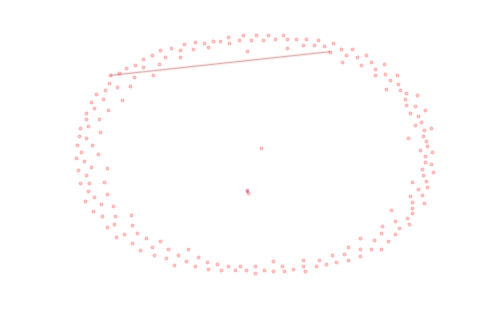

In [25]:
## main simulation

## simulation setup
samples = []
for i in range(number_of_species):    
    s = Species(random.sample(enzymes,enzymes_per_species) ,m_generator,substrate_size)
    samples.extend([s.spawn() for i in range(number_of_samples)])
assert(len(samples)==number_of_species*number_of_samples)


## simulation execution
reactions = [s.develop(random.randint(0,max_age)) for s in samples]
print("average number of reactions", sum(reactions)/len(reactions))

## analysis of the results
corr = itertools.product(m_types,m_types)
corr = [((m1,m2),pearsonr([s.measure_metabolite_level(m1) for s in samples],[s.measure_metabolite_level(m2) for s in samples])) for m1,m2 in corr]
strong = list(filter(lambda x: x[1][1]<0.000001, corr))
print("strong correlations ",len(strong))
positive = list(filter(lambda x: x[1][0]>0, strong))
print("positive correlations ",len(positive))
negative = list(filter(lambda x: x[1][0]<0, strong))
print("negative correlations ",len(negative))
Gp = nx.Graph([e[0] for e in positive])
Gn = nx.Graph([e[0] for e in negative])
G = nx.Graph()
G.add_edges_from([e[0] for e in positive], weight=1)
G.add_edges_from([e[0] for e in negative], weight=-1)

print(G.number_of_nodes())
print(G.size())
print(Gp.size())
print(Gn.size())
cc=sorted(nx.connected_components(G), key = len, reverse=True)
gcc = cc[0]
activem = set([])
for e in enzymes:
    activem.update(set(e.getproductdef()))
    activem.update(set(e.getsubstratedef()))
print("gcc ",len(gcc))
print("used metabolites ", len(activem))
print("intersection ", len(activem.intersection(gcc)))

pos=nx.spring_layout(Gp)
nx.draw(G,pos,
            with_labels=False,
            node_size=10,
            alpha=0.2
            )

nx.draw_networkx_edges(Gn,pos,
                           with_labels=False,
                           edge_color='r',
                           width=3.0,
                           alpha=0.1
                        )
nx.draw_networkx_edges(Gp,pos,
                           with_labels=False,
                           edge_color='b',
                           width=3.0,
                           alpha=0.2
                        )


1514456991.42


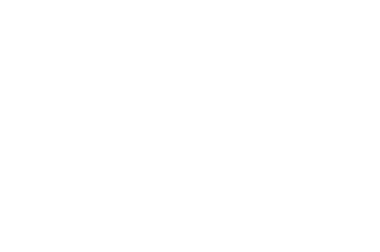

In [26]:
print sim_id
nx.write_edgelist(G,"out/%s_G.csv"%(sim_id), comments="#", delimiter=",", data=["weight"])

random.shuffle(enzymes)

train = enzymes[:enzyme_count // 2]
train_f = open("out/%s_train.txt"%(sim_id),"w")
train_f.write(str(train))

test = enzymes[enzyme_count // 2:] + [Enzyme(Multiset(m_generator(enzyme_size)),Multiset(m_generator(enzyme_size))) for i in range(enzyme_count//2)]
# random.shuffle(test)
test_f = open("out/%s_test.txt"%(sim_id),"w")
test_f.write(str(test))

enzymes = set(enzymes)
ground_truth = [e in enzymes for e in test]
ground_truth_f = open("ground_truth/%s_ground_truth.txt"%(sim_id),"w")
ground_truth_f.write(str(ground_truth))

plt.axis('off')
plt.savefig("out/%s_vis.png"%(sim_id), bbox_inches="tight")
plt.show() 